In [1]:
# Source: https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/404_autoencoder.py

In [2]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [4]:
torch.manual_seed(1)    # reproducible

In [5]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False # Set it to True for the first time
N_TEST_IMG = 5 # number of test images

In [6]:
# load data
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./data/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


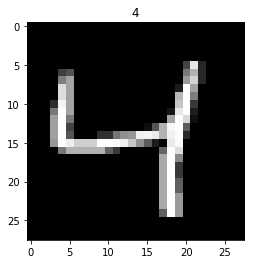

In [19]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray') # ramdomly select the second sample for illustration
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [20]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__() # About super().__init__(): https://stackoverflow.com/questions/576169/understanding-python-super-with-init-methods

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # http://pytorch.org/docs/master/nn.html#linear-layers
            nn.Tanh(), # http://pytorch.org/docs/master/nn.html#torch.nn.Tanh
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR) # learnable params of the modal are returned by autoencoder.parameters()
loss_func = nn.MSELoss()

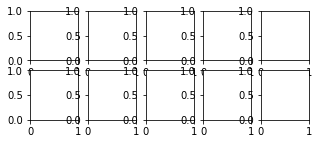

In [11]:
# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2)) # f: figure; a: axes
plt.ion()   # continuously plot. Turn interactive mode on

In [12]:
# original data (first row) for viewing
view_data = torch.tensor(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
print('view_data type = {}'.format(view_data.type()))
print('view_data shape = {}'.format(view_data.data.shape))

view_data type = torch.FloatTensor
view_data shape = torch.Size([5, 784])


In [13]:
# data visualization for first row
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray');
    a[0][i].set_xticks(());
    a[0][i].set_yticks(());

In [14]:
plt.show()

In [15]:
EPOCH = 1
# BATCH_SIZE = 64

In [16]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader): # step: iteration index; x.shape: [BATCH_SIZE, 1, 28, 28]; y.shape: [BATCH_SIZE]   
        b_x = torch.tensor(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = torch.tensor(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = torch.tensor(y)               # batch label

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step since gradients are accumulated in the process
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients. "The function can be called once the gradients are computed using eg. backward()"

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05);
            plt.show();
            

plt.ioff()
plt.show()

Epoch:  0 | train loss: 0.2328


Epoch:  0 | train loss: 0.0690


Epoch:  0 | train loss: 0.0659


Epoch:  0 | train loss: 0.0687


Epoch:  0 | train loss: 0.0681


Epoch:  0 | train loss: 0.0587


Epoch:  0 | train loss: 0.0577


Epoch:  0 | train loss: 0.0554


Epoch:  0 | train loss: 0.0523


Epoch:  0 | train loss: 0.0506


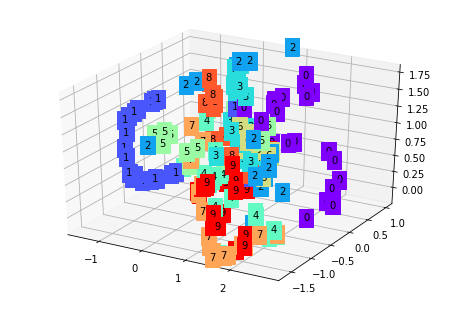

In [17]:
# visualize in 3D plot
view_data = torch.tensor(train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.)
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()

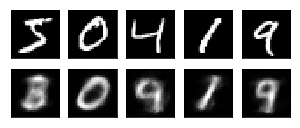

In [18]:
f